# Config

In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class Config:
    """Configuration class for hyperparameters"""
    model_name = "demdecuong/vihealthbert-base-word"
    max_length = 256
    batch_size = 16
    learning_rate = 2e-5 # ~ 0.00002
    weight_decay = 0.01
    num_epochs = 20
    warmup_steps = 100
    dropout_rate = 0.3
    hidden_size = 128
    patience = 5
    gradient_clip = 1.0

# Model DiseaseClass

In [3]:
class DiseaseClassifier(nn.Module):
    """Enhanced classifier for disease prediction"""
    def __init__(self, pretrained_model, num_labels, config):
        super(DiseaseClassifier, self).__init__()
        self.bert = pretrained_model
        self.config = config

        # Freeze some layers for better transfer learning
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Enhanced classifier head
        self.dropout1 = nn.Dropout(config.dropout_rate)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, config.hidden_size)
        self.dropout2 = nn.Dropout(config.dropout_rate)
        self.fc2 = nn.Linear(config.hidden_size, config.hidden_size // 2)
        self.dropout3 = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(config.hidden_size // 2, num_labels)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size // 2)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights properly"""
        for module in [self.fc1, self.fc2, self.classifier]:
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask=None):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use mean pooling instead of just CLS token
        last_hidden_state = outputs.last_hidden_state

        # Mean pooling with attention mask
        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            pooled_output = sum_embeddings / sum_mask
        else:
            pooled_output = torch.mean(last_hidden_state, 1)

        # Forward through enhanced classifier
        x = self.dropout1(pooled_output)
        x = F.relu(self.layer_norm1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.layer_norm2(self.fc2(x)))
        x = self.dropout3(x)
        logits = self.classifier(x)

        return logits


In [4]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [5]:
class HealthBERTTrainer:
    """Enhanced trainer class for disease prediction"""
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Move model to device
        self.model.to(self.device)

        # Optimizer with weight decay
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            verbose=True
        )

        # Early stopping
        self.early_stopping = EarlyStopping(patience=config.patience)

        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

    def train_epoch(self):
        """Train one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)

            self.optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return total_loss / len(self.train_loader), 100. * correct / total

    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)

                total_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return total_loss / len(self.val_loader), 100. * correct / total, all_preds, all_labels

    def train(self):
        """Full training loop"""
        print(f"Training on device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        best_val_loss = float('inf')

        for epoch in range(self.config.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")
            print("-" * 50)

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate()

            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_disease_model.pth')
                print("✓ Saved new best model")

            # Early stopping
            if self.early_stopping(val_loss):
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Load best model
        self.model.load_state_dict(torch.load('best_disease_model.pth'))
        return self.history

In [6]:
def evaluate_model(model, val_loader, label_encoder, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    class_names = label_encoder.classes_
    all_label_indices = list(range(len(class_names)))
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_label_indices, zero_division=0))

    return accuracy, precision, recall, f1

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Load Dataset

In [7]:
def preprocess_text(text):
    """Enhanced text preprocessing for Vietnamese medical text"""
    if isinstance(text, str):
        # Word tokenization for Vietnamese
        segmented = word_tokenize(text, format="text")
        return segmented.strip()
    return ""

In [8]:
import pandas as pd
class DiseaseDataset(Dataset):
    """Dataset class for disease prediction from symptoms"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize with proper padding and truncation
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [9]:
def create_disease_dataset(excelpath):
    try:
        # Đọc file Excel
        df = pd.read_csv(excel_path)
        print(f"Đã đọc {len(df)} dòng dữ liệu từ file csv")

        # Lấy cột 0 (bệnh) và cột 1 (triệu chứng)
        df = df.iloc[:, [0, 1]]  # Cột 0 và cột 1
        df.columns = ['benh', 'trieu_chung']  # Đặt tên cột

        # Loại bỏ các dòng có giá trị null
        df = df.dropna()

        # Chuẩn hóa tên bệnh: thay khoảng trắng bằng dấu gạch dưới
        df['benh'] = df['benh'].str.replace(' ', '_')

        # Tạo mảng tuple (triệu_chứng, bệnh)
        disease_data = []
        for _, row in df.iterrows():
            disease_data.append((str(row['trieu_chung']), str(row['benh'])))

        print(f"Đã tạo {len(disease_data)} mẫu dữ liệu")

        return disease_data

    except Exception as e:
        print(f"Lỗi khi đọc file Excel: {e}")
        return []

# Train Model

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
excel_path = "/content/drive/MyDrive/Colab Notebooks/NLP/health_api/data_processed/augmented_medical_data.csv"

# Tạo dataset
disease_data = create_disease_dataset(excel_path)

# Hiển thị một số mẫu đầu
if disease_data:
    print("\nMột số mẫu dữ liệu:")
    for i, (symptom, disease) in enumerate(disease_data[:10]):
        print(f"{i+1}. ('{symptom}', '{disease}')")

    print(f"\nTổng cộng: {len(disease_data)} mẫu dữ liệu")
else:
    print("Không có dữ liệu")

Đã đọc 580 dòng dữ liệu từ file csv
Đã tạo 580 mẫu dữ liệu

Một số mẫu dữ liệu:
1. ('tôi bị sa trực tràng đồng thời đau khi đi đại tiện, chướng bụng', 'táo_bón')
2. ('tôi phát hiện chướng bụng đồng thời sốt, nôn', 'táo_bón')
3. ('tôi xuất hiện sa trực tràng ngoài ra còn máu trong phân, giảm cân', 'táo_bón')
4. ('tôi có triệu chứng đau bụng đồng thời chướng bụng, giảm cân', 'táo_bón')
5. ('tôi có triệu chứng sa trực tràng ngoài ra còn đau bụng, nôn', 'táo_bón')
6. ('tôi gặp phải máu trong phân đồng thời đau bụng, sốt', 'táo_bón')
7. ('tôi bị sa trực tràng kèm theo chướng bụng, vết nứt hậu môn', 'táo_bón')
8. ('tôi bị sa trực tràng cùng với máu trong phân, sốt', 'táo_bón')
9. ('tôi bị chướng bụng kèm theo giảm cân, nôn', 'táo_bón')
10. ('tôi gặp phải sa trực tràng đồng thời sốt, vết nứt hậu môn', 'táo_bón')

Tổng cộng: 580 mẫu dữ liệu


In [12]:
print("Initializing Enhanced ViHealthBERT Disease Prediction Pipeline")
print("=" * 60)

# Configuration
config = Config()

# Load model and tokenizer
print("Loading pretrained model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
vihealthbert = AutoModel.from_pretrained(config.model_name)

# Prepare data
texts = [sample[0] for sample in disease_data]  # Symptom descriptions
labels = [sample[1] for sample in disease_data]  # Disease labels

print(f"\nDataset Statistics:")
print(f"Total samples: {len(disease_data)}")
print(f"Unique diseases: {len(set(labels))}")

# Show sample data
print(f"\nSample data:")
for i in range(min(5, len(disease_data))):
    print(f"Symptoms: {texts[i]}")
    print(f"Disease: {labels[i]}\n")

# Label encoding
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)

print(f"Disease classes: {list(label_encoder.classes_)}")

# Create dataset
full_dataset = DiseaseDataset(texts, label_ids, tokenizer, config.max_length)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Train samples: {train_size}, Validation samples: {val_size}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


Initializing Enhanced ViHealthBERT Disease Prediction Pipeline
Loading pretrained model and tokenizer...


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]


Dataset Statistics:
Total samples: 580
Unique diseases: 29

Sample data:
Symptoms: tôi bị sa trực tràng đồng thời đau khi đi đại tiện, chướng bụng
Disease: táo_bón

Symptoms: tôi phát hiện chướng bụng đồng thời sốt, nôn
Disease: táo_bón

Symptoms: tôi xuất hiện sa trực tràng ngoài ra còn máu trong phân, giảm cân
Disease: táo_bón

Symptoms: tôi có triệu chứng đau bụng đồng thời chướng bụng, giảm cân
Disease: táo_bón

Symptoms: tôi có triệu chứng sa trực tràng ngoài ra còn đau bụng, nôn
Disease: táo_bón

Disease classes: [np.str_('căng_cơ'), np.str_('cảm_cúm'), np.str_('di_ứng_thực_phẩm'), np.str_('dị_ứng_thời_tiết'), np.str_('hen_suyễn'), np.str_('hạ_canxi_máu'), np.str_('khô_mắt'), np.str_('say_nắng'), np.str_('sỏi_thận'), np.str_('sốt_phát_ban'), np.str_('thiếu_máu'), np.str_('thoái_hoá_cột_sống_cổ'), np.str_('thoái_hoá_cột_sống_lưng'), np.str_('trĩ'), np.str_('trật_khớp'), np.str_('táo_bón'), np.str_('tắc_ruột'), np.str_('viêm_gan_b'), np.str_('viêm_gan_c'), np.str_('viêm_khớp'), np

In [13]:
# Create model
print("Creating enhanced disease prediction model...")
model = DiseaseClassifier(vihealthbert, len(label_encoder.classes_), config)

# Create trainer
trainer = HealthBERTTrainer(model, train_loader, val_loader, config)

# Train model
print("Starting training...")
history = trainer.train()

Creating enhanced disease prediction model...
Starting training...
Training on device: cuda
Model parameters: 135,107,229

Epoch 1/20
--------------------------------------------------


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Validating: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


Train Loss: 3.6681, Train Acc: 2.59%
Val Loss: 3.4163, Val Acc: 4.31%
✓ Saved new best model

Epoch 2/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s]


Train Loss: 3.5181, Train Acc: 5.17%
Val Loss: 3.2087, Val Acc: 6.03%
✓ Saved new best model

Epoch 3/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s]


Train Loss: 3.4024, Train Acc: 6.25%
Val Loss: 2.9780, Val Acc: 27.59%
✓ Saved new best model

Epoch 4/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.74it/s]


Train Loss: 3.1860, Train Acc: 12.72%
Val Loss: 2.7134, Val Acc: 34.48%
✓ Saved new best model

Epoch 5/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Train Loss: 2.9636, Train Acc: 17.89%
Val Loss: 2.4911, Val Acc: 46.55%
✓ Saved new best model

Epoch 6/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]


Train Loss: 2.7737, Train Acc: 26.29%
Val Loss: 2.2865, Val Acc: 50.86%
✓ Saved new best model

Epoch 7/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Train Loss: 2.6722, Train Acc: 28.45%
Val Loss: 2.1276, Val Acc: 61.21%
✓ Saved new best model

Epoch 8/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]


Train Loss: 2.3870, Train Acc: 42.46%
Val Loss: 1.9449, Val Acc: 72.41%
✓ Saved new best model

Epoch 9/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]


Train Loss: 2.2719, Train Acc: 48.28%
Val Loss: 1.8002, Val Acc: 75.00%
✓ Saved new best model

Epoch 10/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Train Loss: 2.1319, Train Acc: 56.47%
Val Loss: 1.6628, Val Acc: 82.76%
✓ Saved new best model

Epoch 11/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Train Loss: 2.0262, Train Acc: 62.93%
Val Loss: 1.5909, Val Acc: 81.90%
✓ Saved new best model

Epoch 12/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]


Train Loss: 1.9666, Train Acc: 62.93%
Val Loss: 1.5149, Val Acc: 87.07%
✓ Saved new best model

Epoch 13/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Train Loss: 1.8536, Train Acc: 69.40%
Val Loss: 1.4418, Val Acc: 83.62%
✓ Saved new best model

Epoch 14/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]


Train Loss: 1.7848, Train Acc: 73.06%
Val Loss: 1.3124, Val Acc: 87.93%
✓ Saved new best model

Epoch 15/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.13it/s]


Train Loss: 1.7165, Train Acc: 77.80%
Val Loss: 1.3095, Val Acc: 89.66%
✓ Saved new best model

Epoch 16/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]


Train Loss: 1.6295, Train Acc: 80.60%
Val Loss: 1.2429, Val Acc: 92.24%
✓ Saved new best model

Epoch 17/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Train Loss: 1.5389, Train Acc: 82.97%
Val Loss: 1.1541, Val Acc: 91.38%
✓ Saved new best model

Epoch 18/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]


Train Loss: 1.5264, Train Acc: 84.27%
Val Loss: 1.0719, Val Acc: 94.83%
✓ Saved new best model

Epoch 19/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]


Train Loss: 1.4728, Train Acc: 83.41%
Val Loss: 1.0503, Val Acc: 95.69%
✓ Saved new best model

Epoch 20/20
--------------------------------------------------


Validating: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]


Train Loss: 1.4357, Train Acc: 89.01%
Val Loss: 1.0360, Val Acc: 96.55%
✓ Saved new best model


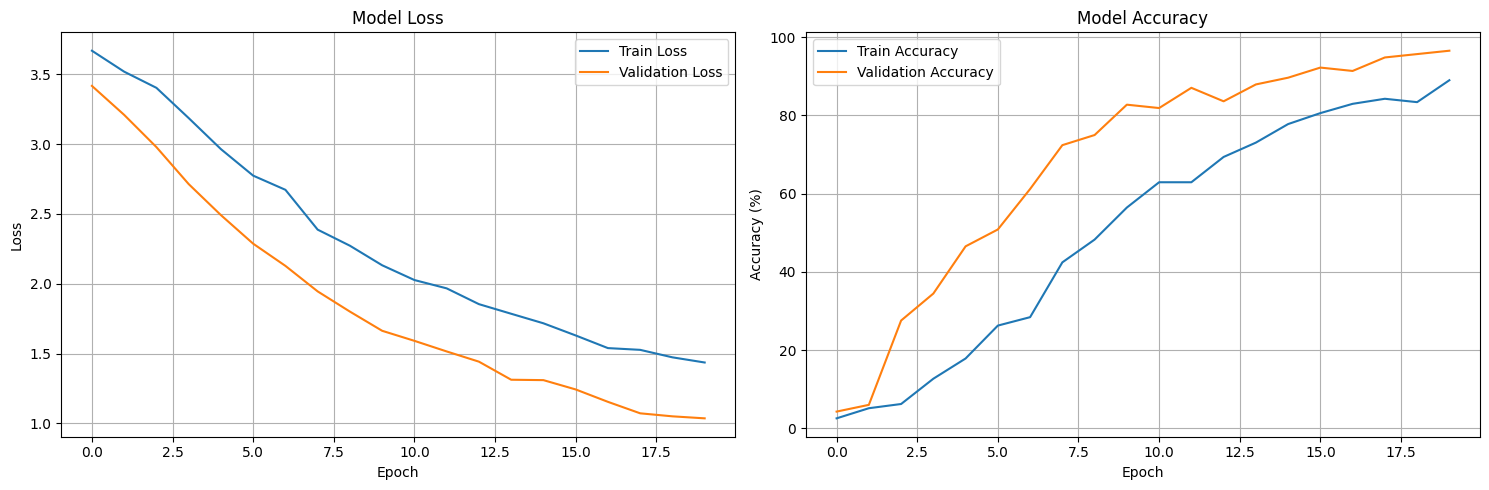

In [14]:
# Plot results
plot_training_history(history)

In [15]:
# Evaluate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_model(model, val_loader, label_encoder, device)

Evaluating: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


Evaluation Results:
Accuracy: 0.9655
Precision: 0.9754
Recall: 0.9655
F1-Score: 0.9662

Detailed Classification Report:
                         precision    recall  f1-score   support

                căng_cơ       1.00      1.00      1.00         4
                cảm_cúm       1.00      0.75      0.86         4
       di_ứng_thực_phẩm       1.00      1.00      1.00         3
       dị_ứng_thời_tiết       1.00      1.00      1.00         4
              hen_suyễn       1.00      1.00      1.00         5
           hạ_canxi_máu       1.00      1.00      1.00         1
                khô_mắt       1.00      1.00      1.00         3
               say_nắng       0.80      1.00      0.89         4
               sỏi_thận       1.00      1.00      1.00         1
           sốt_phát_ban       1.00      1.00      1.00         6
              thiếu_máu       1.00      1.00      1.00         4
  thoái_hoá_cột_sống_cổ       1.00      1.00      1.00         4
thoái_hoá_cột_sống_lưng       1.0

(0.9655172413793104, 0.975383141762452, 0.9655172413793104, 0.9661999596076675)

# Prediction


In [16]:
def predict_disease(model, tokenizer, label_encoder, text, device, max_length=256, top_k=3):
    model.eval()
    processed_text = preprocess_text(text)
    encoding = tokenizer(
        processed_text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    top_indices = np.argsort(probs)[::-1][:top_k]
    top_labels = label_encoder.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    return top_labels, top_probs, probs

def explain_prediction(top_labels, top_scores, threshold=0.5):
    if top_scores[0] >= threshold:
        return f"Bệnh dự đoán: {top_labels[0]} (độ tin cậy: {top_scores[0]:.2f})"
    else:
        return f"Có thể là: {', '.join(top_labels[:2])} (độ tin cậy: {top_scores[0]:.2f}, {top_scores[1]:.2f})"

In [ ]:

# Test predictions with symptom examples
test_cases = [
    " tôi bị chóng mặt buồn nôn",
    "tôi đang bị da bị phù lên, da bị xung huyết, nổi mề đay",
    "tôi bị Sốt cao trên 39.4 độ C,  phát ban, khó chịu, chán ăn"
]

print(f"\n{'='*60}")
print("TESTING DISEASE PREDICTION:")
print(f"{'='*60}")

for test_text in test_cases:
    print(f"\nSymptoms: {test_text}")

    top_labels, top_scores, combined = predict_disease(
        model, tokenizer, label_encoder, test_text, device, max_length=256, top_k=3
    )
    print(explain_prediction(top_labels, top_scores))

    # Show top 3 predictions
    print("Top 3 predictions:")
    for i, label in enumerate(top_labels):
        print(f"  {i+1}. {label}: {top_scores[i]:.4f}")
    print("-" * 50)



TESTING DISEASE PREDICTION:

Symptoms:  tôi bị chóng mặt buồn nôn
Có thể là: cảm_cúm, khô_mắt (độ tin cậy: 0.12, 0.08)
Top 3 predictions:
  1. cảm_cúm: 0.1197
  2. khô_mắt: 0.0793
  3. viêm_gan_b: 0.0743
--------------------------------------------------

Symptoms: tôi đang bị da bị phù lên, da bị xung huyết, nổi mề đay
Bệnh dự đoán: dị_ứng_thời_tiết (độ tin cậy: 0.51)
Top 3 predictions:
  1. dị_ứng_thời_tiết: 0.5064
  2. viêm_xương: 0.0922
  3. trật_khớp: 0.0896
--------------------------------------------------

Symptoms: tôi bị Sốt cao trên 39.4 độ C,  phát ban, khó chịu, chán ăn
Có thể là: viêm_gan_b, viêm_phế_quản (độ tin cậy: 0.14, 0.08)
Top 3 predictions:
  1. viêm_gan_b: 0.1386
  2. viêm_phế_quản: 0.0824
  3. say_nắng: 0.0709
--------------------------------------------------


In [ ]:
# Save the trained model and tokenizer for future use
print("\nSaving trained model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'config': config
}, 'vihealthbert_disease_norules_model.pth')

print("✓ Model saved successfully!")


Saving trained model...
✓ Model saved successfully!
